In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.applications import InceptionResNetV2
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as preprocessing_layers
from tensorflow.math import confusion_matrix

In [2]:
# Confirm GPU connection
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


# Load Pre-Trained Model
Import InceptionResNetV2 pre-trained model - without the final classifying labels. We will append our own binary classifier, by flattening the output of InceptionResNetV2, then adding a fully connected layer and final output layer with a single neuron with sigmoid output.

In [3]:
# Load resnet pretrained on ImageNet
pre_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
pre_model.trainable = False

save_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision'
file_name = 'InceptionResNetV2_summary.txt'
f_path = os.path.join(save_dir, file_name)
with open(f_path, 'w') as f:
  pre_model.summary(print_fn=lambda x: f.write(x + '\n'))
  f.close()

# Plot model to file
# plot_img_file = os.path.join(save_dir, 'pre_model_plot.jpg')
# tf.keras.utils.plot_model(pre_model, to_file=plot_img_file, show_shapes=True) 

219062272/219055592 [==============================] - 1s 0us/step


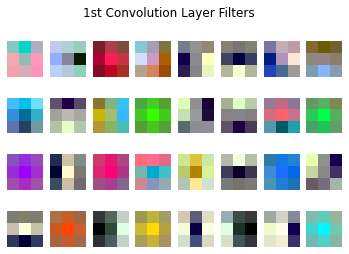

In [4]:
# Visualize inception resnet first layer filters
def getConvLayer(model):
  res = None
  for layer in model.layers:
    if 'conv' in layer.name:
      res = layer
      break
  return res

def normalize(X):
  return (X - np.min(X))/(np.max(X) - np.min(X))

def visualizeFilters(filters):
  nf = filters.shape[3]
  fig, _ = plt.subplots(4,8)
  
  for i, ax in enumerate(fig.axes):
    f = filters[:,:,:,i]
    f = normalize(f)
    ax.imshow(f, cmap='gray')
    ax.set_axis_off()

  fig.suptitle('1st Convolution Layer Filters')
  plt.show()


conv_layer = getConvLayer(pre_model)
visualizeFilters(conv_layer.get_weights()[0])

The filters in the first convolutional layer appear to be small feature detectors. They are color sensitive edge detectors (horizontal and vertical) and blob detectors.

# Build Model
A binary classifier is added to the pre-trained model. The model also specifies preprocessing so it can take raw image data. Data is augmented with horizontal flips, random rotation and zooming to improve generalizability/prevent overfitting to the training data. Another layer rescales pixel values within the range [0,1].

The model is compiled with binary cross entropy loss and RMSprop optimizer, and 'accuracy' metrics are enabled for training.

In [28]:
def binary_img_classifier(base_model):

  data_augmentation = keras.Sequential(
      [
        preprocessing_layers.RandomFlip('horizontal'),
        preprocessing_layers.RandomRotation(0.1),
        preprocessing_layers.RandomZoom(0.1),
      ]
  )

  input_shape = (150,150,3)
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)           #Augment data to increase training set
  x = preprocessing_layers.Rescaling(1.0/255)(x) #Rescale image values to [0,1]

  outputs = base_model(x)
  outputs = layers.Flatten()(outputs) #flatten output of pre_model
  outputs = layers.Dense(256, activation='relu')(outputs) #adds dense layer w/ 256 neurons + ReLU activation
  outputs = layers.Dense(1, activation='sigmoid')(outputs) #output layer w/ single neuron, output in range [0,1]

  model = keras.Model(inputs, outputs)

  model.compile(optimizer='rmsprop',
                metrics=['accuracy'],
                loss='binary_crossentropy')
  
  return model


model = binary_img_classifier(pre_model)
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257 

# Evaluate transfer model before training

In [29]:
def get_preds_labels(model, dat):
  truths = []
  preds = []
  for X,Y in dat:
    truths.append(Y.numpy().astype(int))
    preds.append(model.predict(X))

  preds = np.concatenate(preds, axis=0)
  truths = np.concatenate(truths, axis=0)
  # Threshold at 0.9
  preds = np.where(preds>0.9,1,0).astype(int)
  return (preds, truths)


def show_conf_mat(y_pred, y_true, class_names):
  con_mat = confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  
  fig, ax = plt.subplots()
  ax.matshow(con_mat, cmap='cividis')
  for (i, j), z in np.ndenumerate(con_mat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
  ax.set_xticklabels(['']+class_names)
  ax.set_yticklabels(['']+class_names)
  plt.show()

32/32 [==============================] - 8s 222ms/step - loss: 0.9028 - accuracy: 0.5017


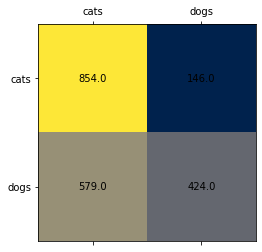

In [31]:
model.evaluate(test_ds)
y_pred, y_true = get_preds_labels(model, test_ds)
show_conf_mat(y_pred.reshape(-1), y_true.reshape(-1), test_ds.class_names)

When running the built-in evaluate function, the model was able to achieve 50% accuracy against the test set of cats & dogs before training. From the confusion matrix, we can see that the pre-trained InceptionResNetV2 model can propertly identify almost 60% of the cat examples, and 74% of the dog examples. InceptionResNetV2 was pre-trained on ImageNet, a dataset which contains examples of cats and dogs.

Initially, the network is miscategorizing a significant amount of cats as dogs. In the following steps, we will fine-tune the network on more images of cats & dogs.

# Import Data
All images are resized to (150x150). The training dataset is split into training & validation datasets. Most of the preprocessing is specified within the model (see above). Note: Rescaling pixel intensities is done within the model.

In [6]:
import tensorflow.keras.preprocessing as preprocessing
from google.colab import drive

print('Importing training and test datasets...\n')
batch_size = 64

train_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/training_set'
all_ds = preprocessing.image_dataset_from_directory(train_path,
                                                    image_size=(150,150),
                                                    shuffle=True,
                                                    label_mode='binary',
                                                    batch_size=batch_size)

val_size = 12
val_ds = all_ds.take(val_size)
train_ds = all_ds.skip(val_size)

test_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/test_set'
test_ds = preprocessing.image_dataset_from_directory(test_path,
                                                     image_size=(150,150),
                                                     label_mode='binary',
                                                     batch_size=batch_size)

Importing training and test datasets...

Found 8282 files belonging to 2 classes.
Found 2003 files belonging to 2 classes.


# Train
The model is compiled with RMSprop optimizer and binary cross-entropy loss function.

Training continues for 5 epochs, with 12 batches from the training dataset designated for validation during fitting.

Weights are saved periodically during training to the "training" directory. When model fitting is complete, the model is saved to "last_trained" directory for future use.

In [ ]:
# Optional: Load previously trained model & SKIP NEXT 2 CODE BLOCKS
model = keras.models.load_model(r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/saved_models/v4_catdog_binaryaccuracy')

In [36]:
# fit model & save weights during training & after
def fit_to_data(model, train_ds, val_ds, epochs=5):
  checkpoint_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training'
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

  history = model.fit(train_ds,
                      epochs=epochs,
                      callbacks=[cp_callback],
                      validation_data=val_ds)

  return history

In [32]:
train_hist_full_model = fit_to_data(model, train_ds, val_ds)
# Save trained model
save_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/last_trained'
model.save(save_path)

Epoch 1/5
118/118 [==============================] - 46s 290ms/step - loss: 2.7002 - accuracy: 0.9002 - val_loss: 0.2511 - val_accuracy: 0.9688

Epoch 00001: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 2/5
118/118 [==============================] - 37s 293ms/step - loss: 0.7210 - accuracy: 0.9236 - val_loss: 0.6088 - val_accuracy: 0.9440

Epoch 00002: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 3/5
118/118 [==============================] - 37s 294ms/step - loss: 0.4308 - accuracy: 0.9352 - val_loss: 0.7284 - val_accuracy: 0.8724

Epoch 00003: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 4/5
118/118 [==============================] - 38s 297ms/step - loss: 0.3747 - accuracy: 0.9381 - val_loss: 0.2033 - val_accuracy: 0.9518

Epoch 00004: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoc

32/32 [==============================] - 8s 222ms/step - loss: 0.0815 - accuracy: 0.9750


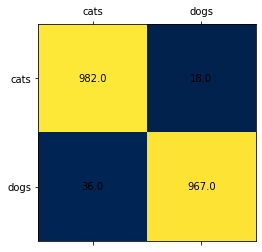

In [33]:
results = model.evaluate(test_ds)

preds, truths = get_preds_labels(model, test_ds)
show_conf_mat(preds.reshape(-1), truths.reshape(-1), test_ds.class_names)

After fitting the model to the training set of cats & dogs, the built-in evaluate function reports an accuracy of 97% against the test set. During training, the reported per-epoch loss against the validation set was: 0.2511, 0.6088, 0.7284, 0.2033, 0.0947. Epochs 2 & 3 saw greater loss and lower accuracy against the validation set - a sign that the model was overfitting to training data. However, performance against the validation set improved in subsequent epochs; with accuracy against the validation set reaching 97% at epoch 5.

The final confusion matrix of predictions against the test set demonstrates that the network was successfully fine-tuned to cats & dogs after training.

# Create Sub-Network
The first 18 layers of the InceptionResNetV2 model are taken to create a new, smaller network. The weights of the pulled sub-network are frozen before training. It's outputs are flattened, fed into a fully-connected layer with 256 neurons and ReLU activation. The final output layer has a single neuron with sigmoid activation.

The summary of the layers pulled from InceptionResNetV2 is shown below.

In [34]:
def get_subnet(original, nlayers):
  sub = keras.Sequential()

  for i,l in enumerate(pre_model.layers):
    if i > nlayers:
      break
    sub.add(l)
  
  return sub

sub_net = get_subnet(pre_model, 18)
sub_net.trainable = False
sub_net.summary()

# Transfer head to sub-network
sub_net = binary_img_classifier(sub_net)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        96        
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)       

# Train & Evaluate Sub-Network
The new network is fit to the training data. During training, accuracy & loss against the training and validation sets are shown (averaged across each epoch). After 5 epochs, accuracy against the validation set increased by 6%.



In [37]:
history_subnet_train = fit_to_data(sub_net, train_ds, val_ds, epochs=10)

Epoch 1/10
118/118 [==============================] - 25s 189ms/step - loss: 0.5401 - accuracy: 0.7411 - val_loss: 0.4915 - val_accuracy: 0.7852

Epoch 00001: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 2/10
118/118 [==============================] - 25s 188ms/step - loss: 0.5192 - accuracy: 0.7505 - val_loss: 0.7393 - val_accuracy: 0.6484

Epoch 00002: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 3/10
118/118 [==============================] - 25s 189ms/step - loss: 0.4956 - accuracy: 0.7600 - val_loss: 0.4507 - val_accuracy: 0.8112

Epoch 00003: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 4/10
118/118 [==============================] - 25s 188ms/step - loss: 0.5095 - accuracy: 0.7587 - val_loss: 0.4509 - val_accuracy: 0.7786

Epoch 00004: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training


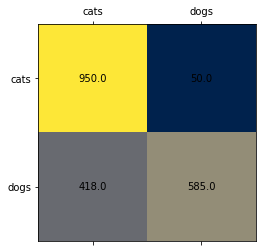

In [38]:
preds, truths = get_preds_labels(sub_net, test_ds)
show_conf_mat(preds.reshape(-1), truths.reshape(-1), test_ds.class_names)

In [39]:
sub_net.evaluate(test_ds)

32/32 [==============================] - 5s 130ms/step - loss: 0.5208 - accuracy: 0.7474


[0.5208051204681396, 0.747378945350647]

The shallower network was not able to perform as well as the deeper network with 5 epochs. The network was only able to achieve 74% accuracy against the training, and 76% against the validation set during training. The final accuracy agains the test set reported by the evaluate function is 49%. The confusion matrix for the test set predictions show an overall accuracy of 70% - appearing to perform only slightly better than the deeper, untrained network. The shallower network may require more training epochs to achieve better performance, and appears to be unable to generalize as well as its deeper counterpart.

By doubling the number of epochs, we start to see the model overfitting to the training data. The per-epoch validation accuracy begins oscillating at epoch 3. However, accuracy against the test set saw 27% increase to 76% (see confusion matrix).